In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image
from PIL import Image
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt

batch_size = 16

/home/wahab/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class SketchPhotoDataset(Dataset):
    def __init__(self, img_dir, sketch_dir, transform=None):
        self.img_dir = img_dir
        self.sketch_dir = sketch_dir
        self.transform = transform
        self.img_list = os.listdir(img_dir)
        self.sketch_list = os.listdir(sketch_dir)

    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        string_idx = str(self.img_list[idx].split('.')[0])
        img_path = os.path.join(self.img_dir, string_idx + '.jpg')
        sketch_path = os.path.join(self.sketch_dir, string_idx + '.jpg')
        
        img = Image.open(img_path).convert('RGB')
        sketch = Image.open(sketch_path).convert('RGB')  # Convert sketch to grayscale
        
        if self.transform:
            img = self.transform(img)
            sketch = self.transform(sketch)
        
        return img, sketch

In [4]:
def rescale_image(image):
    return (image + 1) / 2

6196
203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9666513..1.0].


torch.Size([3, 128, 128])


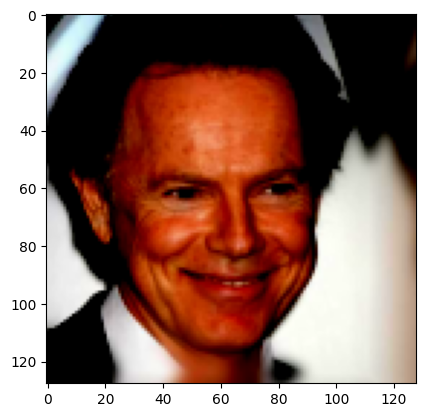

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8480086..0.9971509].


torch.Size([3, 128, 128])


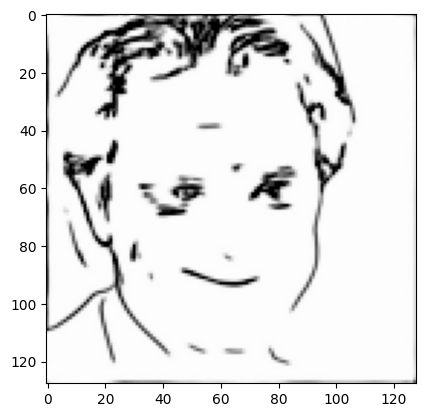

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),          
    transforms.Resize((128, 128)), 
    transforms.Normalize(0.5,0.5),
])

# Load only 10 percent of the training dataset
train_dataset = SketchPhotoDataset(img_dir='./archive/train/photos', sketch_dir='./archive/train/sketches', transform=transform)
test_dataset = SketchPhotoDataset(img_dir='./archive/test/photos', sketch_dir='./archive/test/sketches', transform=transform)
train_size = int(0.3 * len(train_dataset))
test_size = int(0.3 * len(test_dataset))
# Load the testing dataset
train_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, len(train_dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset, _ = torch.utils.data.random_split(test_dataset, [test_size, len(test_dataset) - test_size])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataset))
print(len(test_dataset))

# Example of iterating through the training data
for images, sketches in train_loader:
    plt.imshow(images[0].permute(1, 2, 0))
    print(images[0].shape)
    plt.show()

    plt.imshow(sketches[0].permute(1, 2, 0))
    print(sketches[0].shape)    
    plt.show()
    break

In [6]:
def rescale_image(image):
    return (image + 1) / 2

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_features)
        )
    
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()
        # Initial convolution block
        model = [
            nn.Conv2d(input_nc, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        
        # Downsampling layers
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2
        
        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]
        
        # Upsampling layers
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2
        
        # Output layer
        model += [nn.Conv2d(64, output_nc, kernel_size=7, stride=1, padding=3)]
        model += [nn.Tanh()]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)


In [8]:
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()
        
        model = [
            nn.Conv2d(input_nc, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        model += [
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        model += [
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        model += [
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        model += [nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)


In [9]:
def adversarial_loss(prediction, target_is_real):
    """Binary cross-entropy loss for GANs"""
    target = torch.ones_like(prediction) if target_is_real else torch.zeros_like(prediction)
    return nn.BCEWithLogitsLoss()(prediction, target)

def cycle_consistency_loss(real_image, reconstructed_image, lambda_cycle=10.0):
    """L1 loss for cycle consistency"""
    return lambda_cycle * nn.L1Loss()(reconstructed_image, real_image)


In [10]:
def save_checkpoint(epoch, G_Photo_to_Sketch, G_Sketch_to_Photo, D_Photo, D_Sketch, optimizer_G, optimizer_D_Photo, optimizer_D_Sketch, checkpoint_dir='checkpoints'):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    torch.save({
        'epoch': epoch,
        'G_Photo_to_Sketch_state_dict': G_Photo_to_Sketch.state_dict(),
        'G_Sketch_to_Photo_state_dict': G_Sketch_to_Photo.state_dict(),
        'D_Photo_state_dict': D_Photo.state_dict(),
        'D_Sketch_state_dict': D_Sketch.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_Photo_state_dict': optimizer_D_Photo.state_dict(),
        'optimizer_D_Sketch_state_dict': optimizer_D_Sketch.state_dict(),
    }, os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth'))
    print(f"Checkpoint saved at epoch {epoch}")


def load_checkpoint(checkpoint_path, G_Photo_to_Sketch, G_Sketch_to_Photo, D_Photo, D_Sketch, optimizer_G, optimizer_D_Photo, optimizer_D_Sketch):
    checkpoint = torch.load(checkpoint_path)

    G_Photo_to_Sketch.load_state_dict(checkpoint['G_Photo_to_Sketch_state_dict'])
    G_Sketch_to_Photo.load_state_dict(checkpoint['G_Sketch_to_Photo_state_dict'])
    D_Photo.load_state_dict(checkpoint['D_Photo_state_dict'])
    D_Sketch.load_state_dict(checkpoint['D_Sketch_state_dict'])

    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D_Photo.load_state_dict(checkpoint['optimizer_D_Photo_state_dict'])
    optimizer_D_Sketch.load_state_dict(checkpoint['optimizer_D_Sketch_state_dict'])

    start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
    print(f"Checkpoint loaded, resuming from epoch {start_epoch}")
    return start_epoch


/home/wahab/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/wahab/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [0/100], Step [0/388], D_X Loss: 0.7179105281829834, D_Y Loss: 0.7101755142211914, G Loss: 17.10382652282715
Epoch [0/100], Step [100/388], D_X Loss: 0.6540445685386658, D_Y Loss: 0.9130522012710571, G Loss: 6.039371490478516
Epoch [0/100], Step [200/388], D_X Loss: 0.6878520250320435, D_Y Loss: 0.3399122357368469, G Loss: 4.778966903686523
Epoch [0/100], Step [300/388], D_X Loss: 0.7025159597396851, D_Y Loss: 0.46886324882507324, G Loss: 5.222132682800293


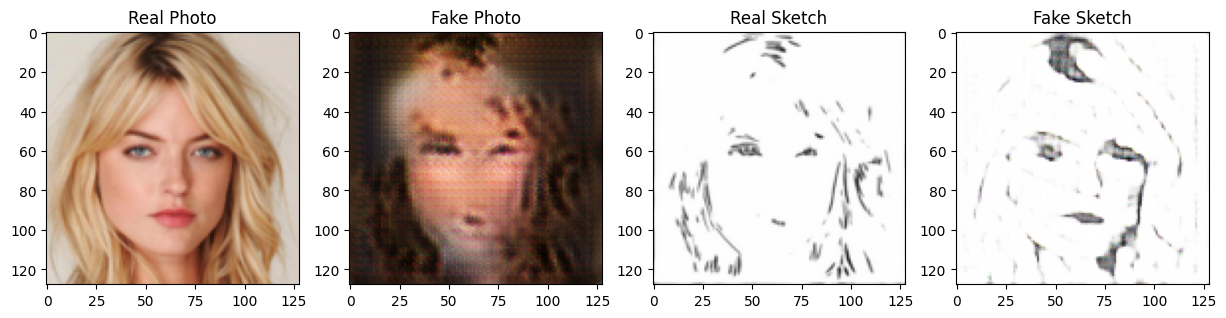

Checkpoint saved at epoch 0
Epoch [1/100], Step [0/388], D_X Loss: 0.6845488548278809, D_Y Loss: 0.25214698910713196, G Loss: 5.38382625579834
Epoch [1/100], Step [100/388], D_X Loss: 0.6654889583587646, D_Y Loss: 0.7751931548118591, G Loss: 3.8404898643493652
Epoch [1/100], Step [200/388], D_X Loss: 0.5732231736183167, D_Y Loss: 0.20329219102859497, G Loss: 4.971981525421143
Epoch [1/100], Step [300/388], D_X Loss: 0.5598135590553284, D_Y Loss: 0.7949491143226624, G Loss: 4.233849048614502
Epoch [2/100], Step [0/388], D_X Loss: 0.5957087278366089, D_Y Loss: 0.4037629961967468, G Loss: 6.418030261993408
Epoch [2/100], Step [100/388], D_X Loss: 0.2874913513660431, D_Y Loss: 0.30581849813461304, G Loss: 7.00307035446167
Epoch [2/100], Step [200/388], D_X Loss: 0.5439358949661255, D_Y Loss: 0.3793241083621979, G Loss: 4.475313186645508
Epoch [2/100], Step [300/388], D_X Loss: 0.6765875816345215, D_Y Loss: 0.383449912071228, G Loss: 5.405371189117432
Epoch [3/100], Step [0/388], D_X Loss: 

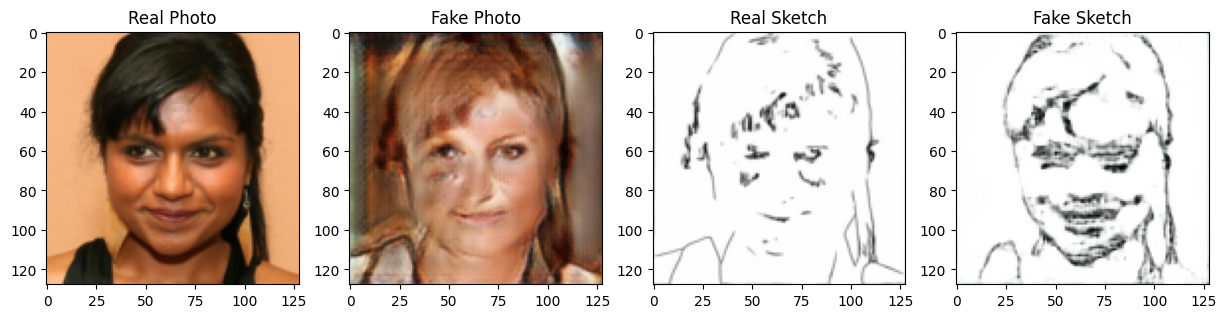

Checkpoint saved at epoch 10
Epoch [11/100], Step [0/388], D_X Loss: 0.6402641534805298, D_Y Loss: 0.23148873448371887, G Loss: 5.328428268432617
Epoch [11/100], Step [100/388], D_X Loss: 0.6001992225646973, D_Y Loss: 0.06647443771362305, G Loss: 6.098241806030273
Epoch [11/100], Step [200/388], D_X Loss: 0.623984694480896, D_Y Loss: 0.11611959338188171, G Loss: 6.025770664215088
Epoch [11/100], Step [300/388], D_X Loss: 0.7037491798400879, D_Y Loss: 0.11469344049692154, G Loss: 7.449113845825195
Epoch [12/100], Step [0/388], D_X Loss: 0.8651124238967896, D_Y Loss: 0.06200651451945305, G Loss: 13.944725036621094
Epoch [12/100], Step [100/388], D_X Loss: 0.4547326862812042, D_Y Loss: 0.00237217522226274, G Loss: 11.946944236755371
Epoch [12/100], Step [200/388], D_X Loss: 0.549189031124115, D_Y Loss: 0.0018452355870977044, G Loss: 13.085527420043945
Epoch [12/100], Step [300/388], D_X Loss: 0.8018574714660645, D_Y Loss: 0.30070987343788147, G Loss: 14.232742309570312
Epoch [13/100], Ste

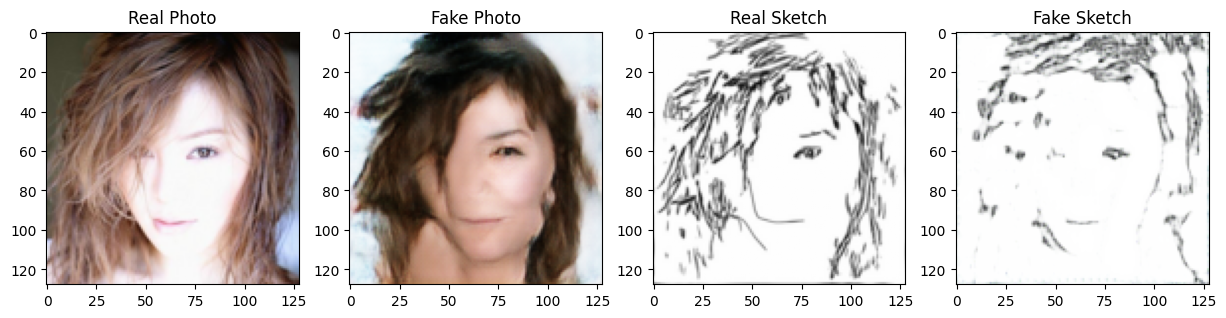

Checkpoint saved at epoch 20
Epoch [21/100], Step [0/388], D_X Loss: 0.5541451573371887, D_Y Loss: 0.049310728907585144, G Loss: 6.167992115020752
Epoch [21/100], Step [100/388], D_X Loss: 0.6837981939315796, D_Y Loss: 0.7562923431396484, G Loss: 3.561491012573242
Epoch [21/100], Step [200/388], D_X Loss: 0.6173960566520691, D_Y Loss: 0.12107308208942413, G Loss: 5.918205261230469
Epoch [21/100], Step [300/388], D_X Loss: 0.5329934358596802, D_Y Loss: 1.113556146621704, G Loss: 3.604602336883545
Epoch [22/100], Step [0/388], D_X Loss: 0.6014314293861389, D_Y Loss: 0.04621062055230141, G Loss: 8.591535568237305
Epoch [22/100], Step [100/388], D_X Loss: 0.5500717163085938, D_Y Loss: 0.01082058809697628, G Loss: 9.943161010742188
Epoch [22/100], Step [200/388], D_X Loss: 0.46975040435791016, D_Y Loss: 0.5305936336517334, G Loss: 3.8736791610717773
Epoch [22/100], Step [300/388], D_X Loss: 0.5439034700393677, D_Y Loss: 0.3863043189048767, G Loss: 4.402220249176025
Epoch [23/100], Step [0/3

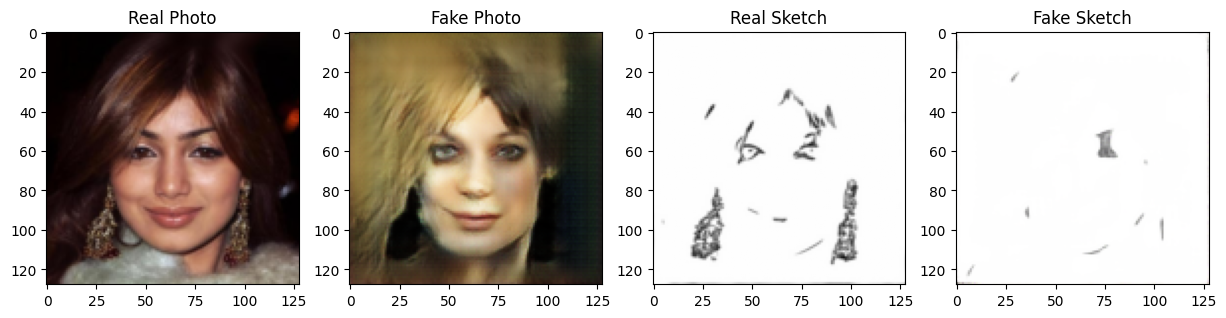

Checkpoint saved at epoch 30
Epoch [31/100], Step [0/388], D_X Loss: 0.7677922248840332, D_Y Loss: 0.07921410351991653, G Loss: 5.36414909362793
Epoch [31/100], Step [100/388], D_X Loss: 0.5439199805259705, D_Y Loss: 0.517320454120636, G Loss: 4.352067470550537
Epoch [31/100], Step [200/388], D_X Loss: 0.5537794828414917, D_Y Loss: 0.07963614165782928, G Loss: 10.639778137207031
Epoch [31/100], Step [300/388], D_X Loss: 0.6086761951446533, D_Y Loss: 0.006993903778493404, G Loss: 11.251214027404785
Epoch [32/100], Step [0/388], D_X Loss: 0.8365936279296875, D_Y Loss: 0.36086711287498474, G Loss: 12.661079406738281
Epoch [32/100], Step [100/388], D_X Loss: 0.6667460203170776, D_Y Loss: 0.5544068813323975, G Loss: 3.525834798812866
Epoch [32/100], Step [200/388], D_X Loss: 0.5344089269638062, D_Y Loss: 0.43824324011802673, G Loss: 4.893576622009277
Epoch [32/100], Step [300/388], D_X Loss: 0.6338465213775635, D_Y Loss: 0.20002520084381104, G Loss: 4.441039085388184
Epoch [33/100], Step [0

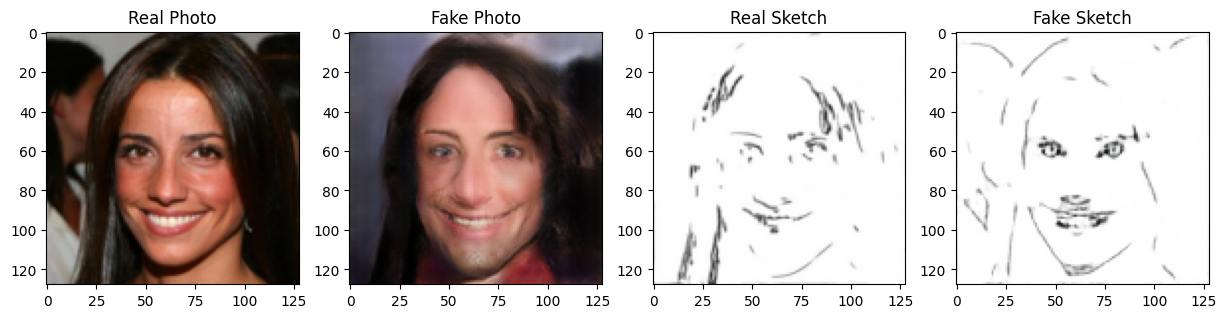

Checkpoint saved at epoch 40
Epoch [41/100], Step [0/388], D_X Loss: 0.4841221272945404, D_Y Loss: 0.12383980304002762, G Loss: 6.5150146484375
Epoch [41/100], Step [100/388], D_X Loss: 0.4916499853134155, D_Y Loss: 0.044491592794656754, G Loss: 12.89964771270752
Epoch [41/100], Step [200/388], D_X Loss: 0.5112364292144775, D_Y Loss: 0.441947340965271, G Loss: 4.3152265548706055
Epoch [41/100], Step [300/388], D_X Loss: 0.6567970514297485, D_Y Loss: 0.06717270612716675, G Loss: 6.014097213745117
Epoch [42/100], Step [0/388], D_X Loss: 0.5442944765090942, D_Y Loss: 0.021837307140231133, G Loss: 11.133840560913086
Epoch [42/100], Step [100/388], D_X Loss: 0.6008673906326294, D_Y Loss: 0.34913015365600586, G Loss: 5.044680595397949
Epoch [42/100], Step [200/388], D_X Loss: 0.5537382364273071, D_Y Loss: 1.0312418937683105, G Loss: 8.033475875854492
Epoch [42/100], Step [300/388], D_X Loss: 0.37046676874160767, D_Y Loss: 0.0052810003980994225, G Loss: 15.306310653686523
Epoch [43/100], Step

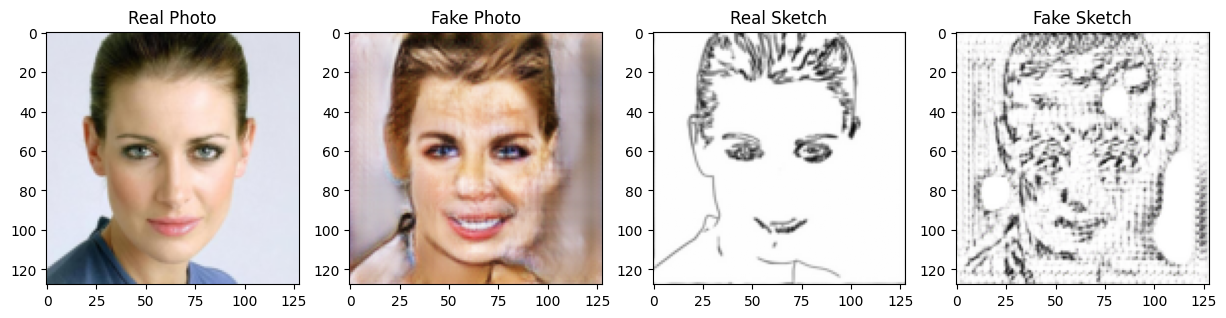

Checkpoint saved at epoch 50
Epoch [51/100], Step [0/388], D_X Loss: 0.5065256357192993, D_Y Loss: 0.06133873388171196, G Loss: 6.5609636306762695
Epoch [51/100], Step [100/388], D_X Loss: 0.4678446054458618, D_Y Loss: 0.1008785143494606, G Loss: 6.310455322265625
Epoch [51/100], Step [200/388], D_X Loss: 0.49031347036361694, D_Y Loss: 0.007941045798361301, G Loss: 11.603086471557617
Epoch [51/100], Step [300/388], D_X Loss: 0.7725523710250854, D_Y Loss: 0.003488424699753523, G Loss: 12.004215240478516
Epoch [52/100], Step [0/388], D_X Loss: 0.45948439836502075, D_Y Loss: 0.5509973764419556, G Loss: 5.754756450653076
Epoch [52/100], Step [100/388], D_X Loss: 0.47412222623825073, D_Y Loss: 0.1355503797531128, G Loss: 7.884781360626221
Epoch [52/100], Step [200/388], D_X Loss: 0.4302407503128052, D_Y Loss: 0.5157060623168945, G Loss: 4.052259922027588
Epoch [52/100], Step [300/388], D_X Loss: 0.5674030780792236, D_Y Loss: 0.40999436378479004, G Loss: 4.009331226348877
Epoch [53/100], Ste

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.008475035..1.0000001].


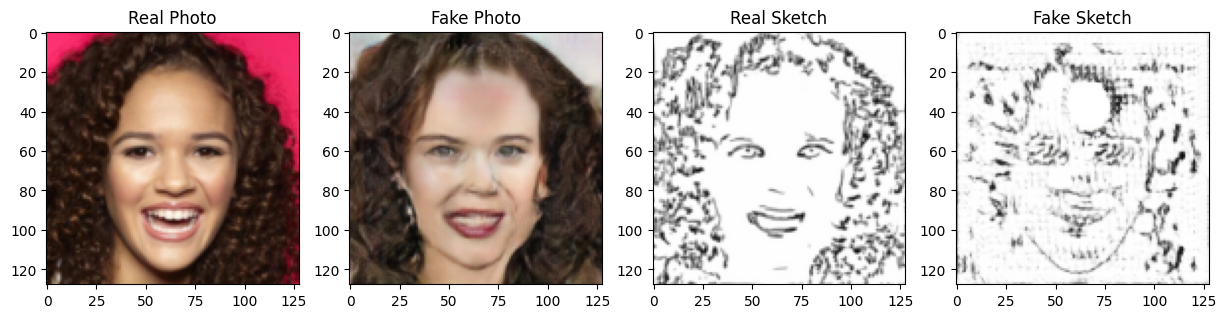

Checkpoint saved at epoch 60
Epoch [61/100], Step [0/388], D_X Loss: 0.3372223973274231, D_Y Loss: 0.03793155029416084, G Loss: 10.612419128417969
Epoch [61/100], Step [100/388], D_X Loss: 0.2599942982196808, D_Y Loss: 0.0038726963102817535, G Loss: 17.912418365478516
Epoch [61/100], Step [200/388], D_X Loss: 0.3445785641670227, D_Y Loss: 0.0030705812387168407, G Loss: 11.82583236694336
Epoch [61/100], Step [300/388], D_X Loss: 0.9563999176025391, D_Y Loss: 0.2893630862236023, G Loss: 6.885575294494629
Epoch [62/100], Step [0/388], D_X Loss: 0.29324883222579956, D_Y Loss: 0.027010686695575714, G Loss: 8.290788650512695
Epoch [62/100], Step [100/388], D_X Loss: 0.5244154930114746, D_Y Loss: 0.004700107499957085, G Loss: 15.990234375
Epoch [62/100], Step [200/388], D_X Loss: 0.3234008550643921, D_Y Loss: 0.6672827005386353, G Loss: 6.240473747253418
Epoch [62/100], Step [300/388], D_X Loss: 0.6567755341529846, D_Y Loss: 0.02096337452530861, G Loss: 7.9664411544799805
Epoch [63/100], Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.003170967..1.0000001].


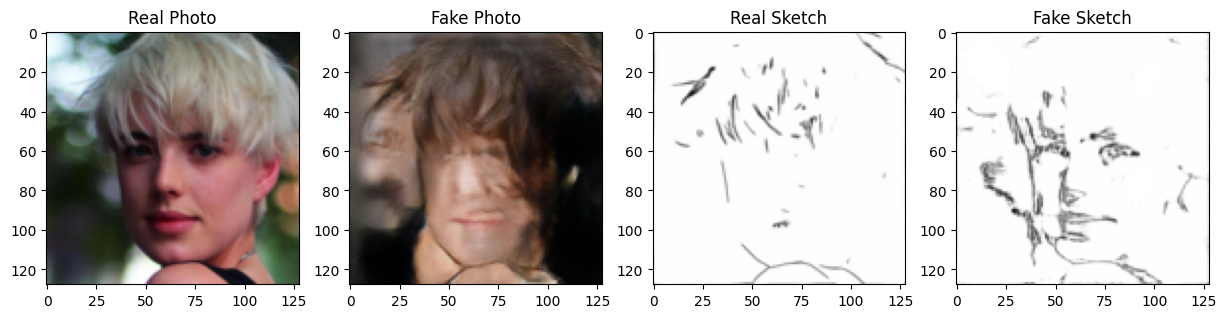

Checkpoint saved at epoch 70
Epoch [71/100], Step [0/388], D_X Loss: 0.23410651087760925, D_Y Loss: 0.6767925024032593, G Loss: 7.984720706939697
Epoch [71/100], Step [100/388], D_X Loss: 0.21607375144958496, D_Y Loss: 0.011975525878369808, G Loss: 10.898969650268555
Epoch [71/100], Step [200/388], D_X Loss: 0.4606848359107971, D_Y Loss: 0.48045724630355835, G Loss: 5.347400188446045
Epoch [71/100], Step [300/388], D_X Loss: 0.31661489605903625, D_Y Loss: 0.03105737268924713, G Loss: 8.920488357543945
Epoch [72/100], Step [0/388], D_X Loss: 0.4909674823284149, D_Y Loss: 0.6625530123710632, G Loss: 5.45522403717041
Epoch [72/100], Step [100/388], D_X Loss: 0.2973206639289856, D_Y Loss: 1.2614262104034424, G Loss: 4.133426189422607
Epoch [72/100], Step [200/388], D_X Loss: 0.3502122163772583, D_Y Loss: 0.006803052965551615, G Loss: 14.747781753540039
Epoch [72/100], Step [300/388], D_X Loss: 0.5136027336120605, D_Y Loss: 0.0057884324342012405, G Loss: 9.657258987426758
Epoch [73/100], St

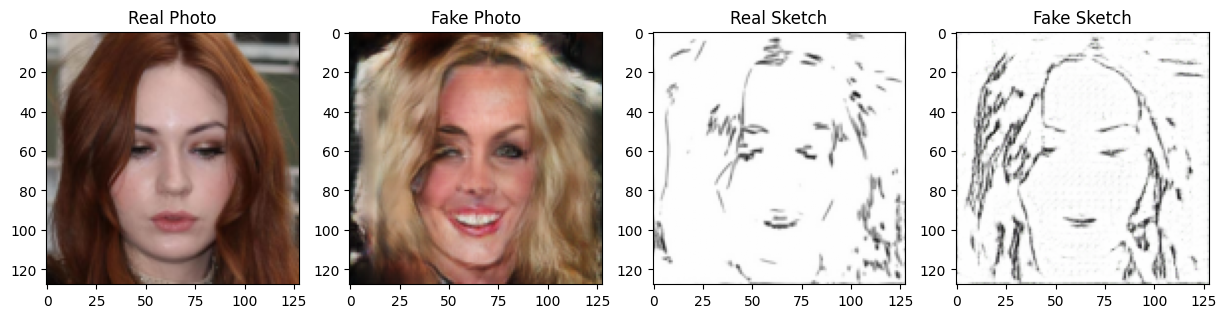

Checkpoint saved at epoch 80
Epoch [81/100], Step [0/388], D_X Loss: 0.3881886899471283, D_Y Loss: 0.4243149161338806, G Loss: 8.106637954711914
Epoch [81/100], Step [100/388], D_X Loss: 0.13676390051841736, D_Y Loss: 0.47472062706947327, G Loss: 5.731393814086914
Epoch [81/100], Step [200/388], D_X Loss: 0.3308974504470825, D_Y Loss: 0.559553325176239, G Loss: 4.534608840942383
Epoch [81/100], Step [300/388], D_X Loss: 0.2653001844882965, D_Y Loss: 0.4185403883457184, G Loss: 5.745299816131592
Epoch [82/100], Step [0/388], D_X Loss: 0.3400997221469879, D_Y Loss: 0.41206908226013184, G Loss: 6.501311302185059
Epoch [82/100], Step [100/388], D_X Loss: 0.3042971193790436, D_Y Loss: 0.3262441158294678, G Loss: 5.371118068695068
Epoch [82/100], Step [200/388], D_X Loss: 0.33396875858306885, D_Y Loss: 0.5145581364631653, G Loss: 5.411002159118652
Epoch [82/100], Step [300/388], D_X Loss: 0.23783425986766815, D_Y Loss: 0.07027813792228699, G Loss: 8.536033630371094
Epoch [83/100], Step [0/38

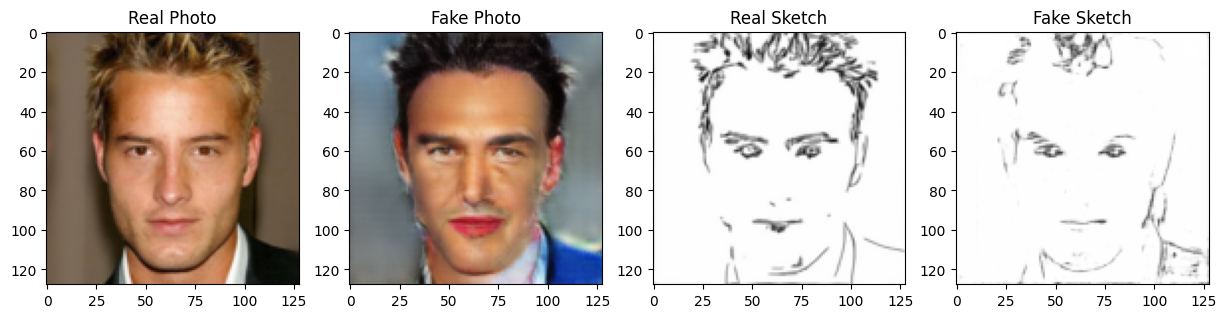

Checkpoint saved at epoch 90
Epoch [91/100], Step [0/388], D_X Loss: 0.33842819929122925, D_Y Loss: 0.38942140340805054, G Loss: 5.913142204284668
Epoch [91/100], Step [100/388], D_X Loss: 0.17564308643341064, D_Y Loss: 0.14676795899868011, G Loss: 6.913871765136719
Epoch [91/100], Step [200/388], D_X Loss: 0.34285661578178406, D_Y Loss: 0.004055385012179613, G Loss: 14.06745719909668
Epoch [91/100], Step [300/388], D_X Loss: 0.28861314058303833, D_Y Loss: 0.012936903163790703, G Loss: 14.748371124267578
Epoch [92/100], Step [0/388], D_X Loss: 0.3457936942577362, D_Y Loss: 0.002456618007272482, G Loss: 14.594279289245605
Epoch [92/100], Step [100/388], D_X Loss: 0.3310640752315521, D_Y Loss: 1.9514226913452148, G Loss: 9.27150821685791
Epoch [92/100], Step [200/388], D_X Loss: 0.35908451676368713, D_Y Loss: 0.4857296347618103, G Loss: 5.978559970855713
Epoch [92/100], Step [300/388], D_X Loss: 0.3106082081794739, D_Y Loss: 0.4388424754142761, G Loss: 5.784907817840576
Epoch [93/100], S

In [11]:
# Initialize generators and discriminators
G_Photo_to_Sketch = Generator(input_nc=3, output_nc=3, n_residual_blocks=6).cuda()
G_Sketch_to_Photo = Generator(input_nc=3, output_nc=3, n_residual_blocks=6).cuda()
D_Photo = Discriminator(input_nc=3).cuda()
D_Sketch = Discriminator(input_nc=3).cuda()

num_epochs = 100
checkpoint_dir = 'checkpoints'
interval = 10

# Optimizers
optimizer_G = optim.Adam(itertools.chain(G_Photo_to_Sketch.parameters(), G_Sketch_to_Photo.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_Photo = optim.Adam(D_Photo.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_Sketch = optim.Adam(D_Sketch.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
for epoch in range(num_epochs):
    for i, (photos, sketches) in enumerate(train_loader):
        photos, sketches = photos.to(device), sketches.to(device)
        
        # Generate fake images
        fake_sketch = G_Photo_to_Sketch(photos)
        fake_photo = G_Sketch_to_Photo(sketches)
        
        # Calculate the loss for the generators
        loss_G_Photo_to_Sketch = adversarial_loss(D_Sketch(fake_sketch), True)
        loss_G_Sketch_to_Photo = adversarial_loss(D_Photo(fake_photo), True)
        loss_cycle_A = cycle_consistency_loss(photos, G_Sketch_to_Photo(fake_sketch))
        loss_cycle_B = cycle_consistency_loss(sketches, G_Photo_to_Sketch(fake_photo))
        # Total generator loss
        loss_G = loss_G_Photo_to_Sketch + loss_G_Sketch_to_Photo + loss_cycle_A + loss_cycle_B
        
        # Backpropagation for the generators
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        
        # Calculate the loss for the discriminators
        loss_D_Photo_real = adversarial_loss(D_Photo(photos), True)
        loss_D_Photo_fake = adversarial_loss(D_Photo(fake_photo.detach()), False)
        loss_D_Photo = (loss_D_Photo_real + loss_D_Photo_fake) / 2
        
        loss_D_Sketch_real = adversarial_loss(D_Sketch(sketches), True)
        loss_D_Sketch_fake = adversarial_loss(D_Sketch(fake_sketch.detach()), False)
        loss_D_Sketch = (loss_D_Sketch_real + loss_D_Sketch_fake) / 2
        
        # Backpropagation for the discriminators
        optimizer_D_Photo.zero_grad()
        loss_D_Photo.backward()
        optimizer_D_Photo.step()
        
        optimizer_D_Sketch.zero_grad()
        loss_D_Sketch.backward()
        optimizer_D_Sketch.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], "
                  f"D_X Loss: {loss_D_Photo.item()}, D_Y Loss: {loss_D_Sketch.item()}, G Loss: {loss_G.item()}")

    if epoch % 10 == 0:
        with torch.no_grad():
            fake_sketch = G_Photo_to_Sketch(photos)
            fake_photo = G_Sketch_to_Photo(sketches)
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 4, 1)
            plt.imshow(rescale_image(photos[0].cpu()).permute(1, 2, 0).squeeze(), cmap='gray')
            plt.title('Real Photo')
            plt.subplot(1, 4, 2)
            plt.imshow(rescale_image(fake_photo[0].cpu()).permute(1, 2, 0))
            plt.title('Fake Photo')
            plt.subplot(1, 4, 3)
            plt.imshow(rescale_image(sketches[0].cpu()).permute(1, 2, 0))
            plt.title('Real Sketch')
            plt.subplot(1, 4, 4)
            plt.imshow(rescale_image(fake_sketch[0].cpu()).permute(1, 2, 0).squeeze(), cmap='gray')
            plt.title('Fake Sketch')
            plt.show()
        save_checkpoint(epoch, G_Photo_to_Sketch, G_Sketch_to_Photo, D_Photo, D_Sketch, optimizer_G, optimizer_D_Photo, optimizer_D_Sketch, checkpoint_dir)

In [12]:
torch.save(G_Photo_to_Sketch.state_dict(), './model/G_Photo_to_Sketch.pth')
torch.save(G_Sketch_to_Photo.state_dict(), './model/G_Sketch_to_Photo.pth')
torch.save(D_Photo.state_dict(), './model/D_Photo.pth')
torch.save(D_Sketch.state_dict(), './model/D_Sketch.pth')